# **Análise Exploratória de Dados de Logística**


## 1\. Contexto

O Conjunto de dados utilizado nesse notebook, são sintetizados por fonte de dados públicas (como IPEA, IBGE e outras fontes), e disponibilizado pela empresa [Loggi](https://www.loggi.com/). Onde, tais dados tem como finalidade representar desafios que a startup enfrenta no seu dia a dia, especialmente com relação a sua escala de entregas.<br>
Além disso, esses dados que pretendo trabalhar, trata-se de um recorte do conjunto de dados da região do Distrito Federal Brasileiro, refente ao repositório  [Loggi Benchmark for Urban Deliveries](https://github.com/loggi/loggibud/blob/master/docs/quickstart.md).
<br><br>
**Quem é a Loggi?**
<br>
A Loggi é uma startup unicórnio brasileira de tecnologia focada no mercado de **logística**. A Loggi iniciou a sua jornada com a entrega de documentos entre 2013 e 2014. Anos depois, entrou no segmento de e-commerce. Desde 2017, tem atuado nas entregas de alimentos. Em 2020, recebeu grandes aportes de investimentos  internacionais visando o potencial crescimento da empresa. E em 2021, fechou o ano com valor de mercado de [US$ 2 bilhões](https://forbes.com.br/forbes-tech/2021/08/o-mundo-dos-unicornios-loggi/), além de mais de 40 mil entregadores cadastrados em vários países.
<br><br>
**Objetivo desse Projeto**: 
Verificar a logística dos pontos de distribuição (Hub) do Distrito Federal, apontando as maiores regiões de entregas, além de explanar se existem pontos de distribuição com demanda ociosa. 
<br><br>
**Destaque para os dados**:
<br>
Onde as variáveis disponibilizadas pela base de dados da Loggi são descritas:

- **name**: uma `string` com o nome único da instância;
- **region**: uma `string` com o nome único da região do **hub**;
- **origin**: um `dict` com a latitude e longitude da região do **hub**;
- **vehicle_capacity**: um `int` com a soma da capacidade de carga dos **veículos** do **hub**;
- **deliveries**: uma `list` de `dict` com as **entregas** que devem ser realizadas.

Sendo que:

 - **id**: uma `string` com o id único da **entrega**;
 - **point**: um `dict` com a latitude e longitude da **entrega**;
 - **size**: um `int` com o tamanho ou a carga que a **entrega** ocupa no **veículo**.

## 2\. Pacotes e bibliotecas

In [1]:
# instalação do havesine:
!pip install haversine

#instalação do geopandas
!pip3 install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Bibliotecas utilizadas:

import requests
import json

import pandas as pd
import numpy as np
import geopandas
import folium
import geopy
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from haversine import haversine


## 3\. Exploração de dados

In [3]:
#URL da base de dados:
URL = "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json"

In [4]:
#Requistando as informações da base de dados (formato JSON):
request = requests.get(URL)

In [5]:
# Criando o DataFrame:
df = pd.DataFrame(request.json())

In [6]:
# Criando dataframe com as informações das latitudes e longitude de cada região:
df_origen = pd.json_normalize(df["origin"])

In [7]:
# juntando as informações ao dataframe central:
df = pd.merge(left=df, right=df_origen, left_index=True, right_index=True)
# Selecionando as colunas para trabalhar no DataFrame central:
df = df[['name', 'region', 'lng','lat','vehicle_capacity', 'deliveries']]


In [8]:
# Explorando os dados aninhados na coluna deliveries,
# utilizando o método explode para extrair as informações por linha:
entregas_expandidas = df[['deliveries']].explode("deliveries")
# criando o DataFrame de entregas com as respectivas colunas deliveries:
df_entregas = pd.concat( [
    pd.DataFrame(entregas_expandidas["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "deliveries_size"}),
    pd.DataFrame(entregas_expandidas["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "deliveries_lng"}),
    pd.DataFrame(entregas_expandidas["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "deliveries_lat"})
], axis= 1)   


In [9]:
# Selecionando as colunas do DataFrame Central:
df = df[['name', 'region', 'lng','lat','vehicle_capacity']]

# Renomeando as colunas lng e lat para facilitar a sua intepretação:
df.rename(columns={'lng':'hub_lng','lat':'hub_lat'}, inplace=True)

# Mesclando os DataFrame Entregas ao DataFrame Central:
df_deliveries = pd.merge(left=df, right=df_entregas, how='right', left_index=True, right_index=True)

# Organizando os index:
df_deliveries.reset_index(inplace=True, drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
# consultando as informações do Dataframe (Dtypes e número de elementos):
df_deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   deliveries_size   636149 non-null  int64  
 6   deliveries_lng    636149 non-null  float64
 7   deliveries_lat    636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


## 4\. Manipulação e Enriquecimento dos Geodados

In [11]:
# Primeiro, será necessário manipular os dados dos pontos de distribuição (hub).
# Ou seja, será preciso criar um DataFrame para manusear as informações dos Hub's:
df_hub = df_deliveries[["region", "hub_lng", "hub_lat"]]#selecionando as colunas hub.
# Eliminando itens duplicados e reestruturando os índex:
df_hub = df_hub.drop_duplicates().sort_values(by="region").reset_index(drop=True)
df_hub.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


###4.1 Geocodificação reversa dos dados de distribuição Hubs

In [12]:
# Agora com as informações do DataFrame hub, será aplicado a geocodificação reversa.
# Esse processo, é responsável por pegar as informações das coordenadas geográficas de um
# local, e transformar em descrições textuais as características de localização
# (como endereço, nome do local, posição e etc).

# Para começar a geocodificação reversa. Será preciso fazer a solicitação de acesso 
# à aplicação Nominatim (que é uma API open source), e requer um intervalo de 1 segundo 
# a cada consulta realizada.  
geolocator = Nominatim(user_agent="sergio_carvalho") #fazendo login.

#Fazendo a geocodificação reversa com as coordenadas do Distrito Federal:
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

# Configurando o limitador de taxa e adicionando o intervalo de 1 segundo para consultas:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)


In [13]:
# Agora será preciso criar uma nova coluna, que será responsável por registrar
# as coordenadas completas dos três pondos de distribuição Hub:
df_hub["coordinates"] = df_hub["hub_lat"].astype(str)  + ", " + df_hub["hub_lng"].astype(str)

# Em seguida, uma nova coluna será criada para registrar as informações da aplicação
# do geocoder sobre a coluna de coordinates utilizando o método apply:
df_hub["geodata"] = df_hub["coordinates"].apply(geocoder)

df_hub.head()#Exibindo o dataframe.

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíl..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [14]:
# Com as informações presente na coluna geodata do DataFrame hub, será preciso
# exportar essas informações para um novo DataFrame, que vai extrair as informações
# das linhas e converter em colunas:

# Utilizando o método normalize  do Pandas para expandir as informações presente nas linhas
# da coluna geodata:
df_hub_geodata = pd.json_normalize(df_hub["geodata"].apply(lambda data: data.raw))
df_hub_geodata.head()#exibindo o novo DataFrame.


,place_id,licence,osm_type,osm_id,lat,lon,display_name,boundingbox,address.amenity,address.road,...,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.building,address.neighbourhood,address.city,address.shop,address.house_number
0,68906480,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6456379935,-15.656819,-47.8019514,"Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho...","[-15.656869, -15.656769, -47.8020014, -47.8019...",Clinica dos Olhos,Rua 7,...,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,138610967,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,140908717,-15.80443735,-47.893155456691616,"Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíli...","[-15.805071, -15.8038038, -47.8937468, -47.892...",NaN,W1 Sul,...,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,Bloco B / F,SQS 103,Brasília,NaN,NaN
2,67585484,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,"Armazém do Bolo, lote 4/8, CSB 4/5, Taguatinga...","[-15.8384871, -15.8383871, -48.0553417, -48.05...",NaN,CSB 4/5,...,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [15]:
# Para facilitar a manipulação dos dados obtidos, será preciso selecionar
# as colunas de destaque.
# Listando todas as colunas obtidas no processo da normalização:
display(df_hub_geodata.columns)


Index(['place_id', 'licence', 'osm_type', 'osm_id', 'lat', 'lon',
       'display_name', 'boundingbox', 'address.amenity', 'address.road',
       'address.residential', 'address.suburb', 'address.town',
       'address.municipality', 'address.county', 'address.state_district',
       'address.state', 'address.ISO3166-2-lvl4', 'address.region',
       'address.postcode', 'address.country', 'address.country_code',
       'address.building', 'address.neighbourhood', 'address.city',
       'address.shop', 'address.house_number'],
      dtype='object')

In [16]:
# Selecionando as colunas de maior destaque para geolocalização dos hubs no Distrito Federal:
df_hub_geodata = df_hub_geodata[["address.town", "address.suburb", "address.city"]]

# Renomeando as colunas:
df_hub_geodata.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)

# Utilizando o método where da biblioteca Numpy para identificar se existem
# elementos nulos nas colunas do DataFrame hub geodata, caso exista valores nulos,
# será substituido pelo valor sugerido:
df_hub_geodata["hub_city"] = np.where(df_hub_geodata["hub_city"].notna(), df_hub_geodata["hub_city"], df_hub_geodata["hub_town"])
df_hub_geodata["hub_suburb"] = np.where(df_hub_geodata["hub_suburb"].notna(), df_hub_geodata["hub_suburb"], df_hub_geodata["hub_city"])

# Eliminando a coluna hub_town:
df_hub_geodata.drop(columns="hub_town", inplace=True, errors='ignore')

# Exibindo o DataFrame com a informação dos bairros e cidades:
df_hub_geodata.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [17]:
# Agora será preciso combinar as informações dos DataFrames hub geodata, com o hub.
# Essa combinação vai ocorrer pela junção inner join, ligando os index dos DataFrames:
df_hub = pd.merge(left=df_hub, right=df_hub_geodata, how='inner', left_index=True, right_index=True)

# Selecionando as colunas de maior destaque para o DataFrame Hub:
df_hub = df_hub[['region','hub_lng','hub_lat','hub_suburb','hub_city']]

# Com as informações mais detalhas no DataFrame Hub (cidades e bairros), é possível
# combinar as informações ao DataFrame deliveries:
df_deliveries = pd.merge(left=df_hub, right=df_deliveries, how='inner', on='region')


# Removendo a colunas do DataFrame Deliveries:
df_deliveries.drop(columns=['hub_lng_x', 'hub_lat_x', 'name'], inplace=True)

# Renomeando as colunas 'hub_lng_y', 'hub_lat_y':
df_deliveries.rename(columns={'hub_lng_y':'hub_lng', 'hub_lat_y':'hub_lat'}, inplace=True)

df_deliveries.head()

,region,hub_suburb,hub_city,hub_lng,hub_lat,vehicle_capacity,deliveries_size,deliveries_lng,deliveries_lat
0,df-0,Sobradinho,Sobradinho,-47.802665,-15.657014,180,3,-47.754844,-15.651816
1,df-0,Sobradinho,Sobradinho,-47.802665,-15.657014,180,4,-47.757320,-15.648223
2,df-0,Sobradinho,Sobradinho,-47.802665,-15.657014,180,5,-47.756113,-15.652011
3,df-0,Sobradinho,Sobradinho,-47.802665,-15.657014,180,3,-47.758499,-15.653910
4,df-0,Sobradinho,Sobradinho,-47.802665,-15.657014,180,3,-47.755965,-15.653289


### 4.1 Manipulando os Dados de entrega (deliveries)

In [18]:
# Como o uso da API Nominatim requer um intervalo de 1 segundo para cada consulta,
# a sua utilização no volume de dados de entrega (ou seja, deliveries),
# demandaria um intervalo de tempo muito grande. Visto que, os dados de entrega totalizam
# 636.149 linhas, o que levaria 176 horas (ou 7 dias) tornando esse processo inviável
# através da consulta online da API.

# Como forma de solucionar esse problema, seria a opção de baixar a ferramenta 
# Nominatim e rodar ela via Docker em sua própria máquina. Utilizando assim,
# recursos próprios como memória e processador.

# Mas como forma de simplificar esse processo, segue abaixo o link de um arquivo
# csv, já contendo o processamento dos dados de entregas.

#URL do arquivo "geodata deliveries":
URL_deliveries = "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv"

# Criação do DataFrame Pandas usando a URL arquivo "geodata deliveries":
df_geodata_deliveries = pd.read_csv(filepath_or_buffer=URL_deliveries, sep=',')

In [19]:
# Selecionando as colunas do DataFrame geodata deliveries:
df_geodata_deliveries = df_geodata_deliveries[['delivery_suburb','delivery_city']]

# Juntando os DataFrames geodata deliveries, ao DataFrame deliveries através dos index:
df_deliveries = pd.merge(left=df_deliveries, 
                         right=df_geodata_deliveries, 
                         how="inner", 
                         left_index=True, 
                         right_index=True)


In [20]:
# Enriquecendo o DataFrame Deliveries com mais informações geográficas. 
# Criando a coluna de distância percorrida para entrega:
df_deliveries['delivery_distance'] = df_deliveries.index #indexando o conteúdo do DataFrame a coluna.
lista_distancia = list() #lista para registrar a informação da distância em Km.

# Loop responsável por fazer a leitura da distância entre os pontos
# de distribuições, até os pontos de entregas:
for i in df_deliveries['delivery_distance']:
  i = round(haversine((df_deliveries['hub_lat'][i], df_deliveries['hub_lng'][i]), (df_deliveries['deliveries_lat'][i], df_deliveries['deliveries_lng'][i])),4)
  lista_distancia.append(i)

# Alimentando a coluna delivery_distance, com a informação presente na lista_distancia:
df_deliveries['delivery_distance'] = lista_distancia


# exibindo o dataframe deliveries:
df_deliveries.head()

,region,hub_suburb,hub_city,hub_lng,hub_lat,vehicle_capacity,deliveries_size,deliveries_lng,deliveries_lat,delivery_suburb,delivery_city,delivery_distance
0,df-0,Sobradinho,Sobradinho,-47.802665,-15.657014,180,3,-47.754844,-15.651816,P Sul,Ceilândia,5.1528
1,df-0,Sobradinho,Sobradinho,-47.802665,-15.657014,180,4,-47.757320,-15.648223,P Sul,Ceilândia,4.9526
2,df-0,Sobradinho,Sobradinho,-47.802665,-15.657014,180,5,-47.756113,-15.652011,P Sul,Ceilândia,5.0153
3,df-0,Sobradinho,Sobradinho,-47.802665,-15.657014,180,3,-47.758499,-15.653910,P Sul,Ceilândia,4.7414
4,df-0,Sobradinho,Sobradinho,-47.802665,-15.657014,180,3,-47.755965,-15.653289,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,5.0172


<p>Explicação: a biblioteca havesine calcula a distância entre dois ponto através de suas coordenadas.</p>
<p>Porém, é preciso se atentar a um detalhe, essa distância é calculada ignorando o fato da existência obstáculos (como barreiras físicas, curvas, aclives e declives), ou seja, observado apenas o plano sobre uma reta não euclidiana.</p>


In [21]:
# Verificando as informações do DataFrame deliveries (Dtypes e número de elementos):
df_deliveries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   region             636149 non-null  object 
 1   hub_suburb         636149 non-null  object 
 2   hub_city           636149 non-null  object 
 3   hub_lng            636149 non-null  float64
 4   hub_lat            636149 non-null  float64
 5   vehicle_capacity   636149 non-null  int64  
 6   deliveries_size    636149 non-null  int64  
 7   deliveries_lng     636149 non-null  float64
 8   deliveries_lat     636149 non-null  float64
 9   delivery_suburb    476264 non-null  object 
 10  delivery_city      634447 non-null  object 
 11  delivery_distance  636149 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 79.2+ MB


In [22]:
# Observando a proporção dos elementos que estão faltando no DataFrame: 
round(df_deliveries.isna().sum()/len(df_deliveries),4)*100


region                0.00
hub_suburb            0.00
hub_city              0.00
hub_lng               0.00
hub_lat               0.00
vehicle_capacity      0.00
deliveries_size       0.00
deliveries_lng        0.00
deliveries_lat        0.00
delivery_suburb      25.13
delivery_city         0.27
delivery_distance     0.00
dtype: float64

**Observação**: Com relação a essa proporção de elementos faltosos na coluna "delivery_suburb", é preciso ter atenção na hora de analisar seus dados. Já com relação à coluna "delivery_city", a sua relação de elementos faltosos não apresenta tanta significância.     

## 5\. Visualização

###5.1 Visualização Espacial

In [23]:
# Para melhor situar a compreensão da localização dos pontos de distribuição (hub)
# vou utilizar a biblioteca folium para criar o mapa de exibição:
# Mapa do Distrito Federal.
mapa = folium.Map(location=(-15.7801, -47.9292), zoom_start=11, titles= 'Mapa dos Pontos de Distribuição da Loggi em Brasília')
for index, row in df_hub.iterrows():
  folium.CircleMarker(location=(row['hub_lat'],row['hub_lng']),
                radius=50, 
                popup="Pontos de Distribuição",
                color='blue',
                fill=True,
                fill_color='blue').add_to(mapa)


display(mapa)

Com base no mapa exposto acima, é possível compreender que os Hub's estão de fato localizados em Sobradinho, Brasília e Taguatinga.

Com essa informação em mente, agora pretendo criar um mapa com a distribuição espacial das entregas feitas pelos pontos de distribuição Hub's na região do Distrito Federal.
Para conseguir construir esse mapa, será necessário baixar os dados de geolocalização do Distrito Federal, disponibilizados pelo IBGE em seu [site](https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip).

In [24]:
# Primeiro, para baixar esse arquivo, será preciso utilizar o comando linux 
# wget que puxar as informações do site do IBGE via hiper link
# (OBS: o arquivo do site está no formato .zip):
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
# Em seguinda, como o arquivo se encontra zipado, será preciso utilizar outro
# comando unzip para extrair as informações do arquivo baixo:
!unzip -q distrito-federal.zip -d ./maps
# # Por fim, o comando cp vai copiar os arquivos no formato .shp e .shx
# referente ao Distrito Federal e salvar no diretório (pasta) raiz:
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [25]:
# Criando o DataFrame map com os dados de geolocalização:
df_map = geopandas.read_file("distrito-federal.shp")

# Selecionando a primeira linha do DataFrame map:
df_map = df_map.loc[[0]]


In [26]:
# Criação do DataFrame geo_hub (com  as posições espaciais dos Hub's): 
df_geo_hub = geopandas.GeoDataFrame(df_hub, geometry=geopandas.points_from_xy(df_hub["hub_lng"], df_hub["hub_lat"]))


In [27]:
# Criação do DataFrame geo_deliveries (com  as posições espaciais das entregas):
df_geo_deliveries = geopandas.GeoDataFrame(df_deliveries, geometry=geopandas.points_from_xy(df_deliveries["deliveries_lng"], df_deliveries["deliveries_lat"]))


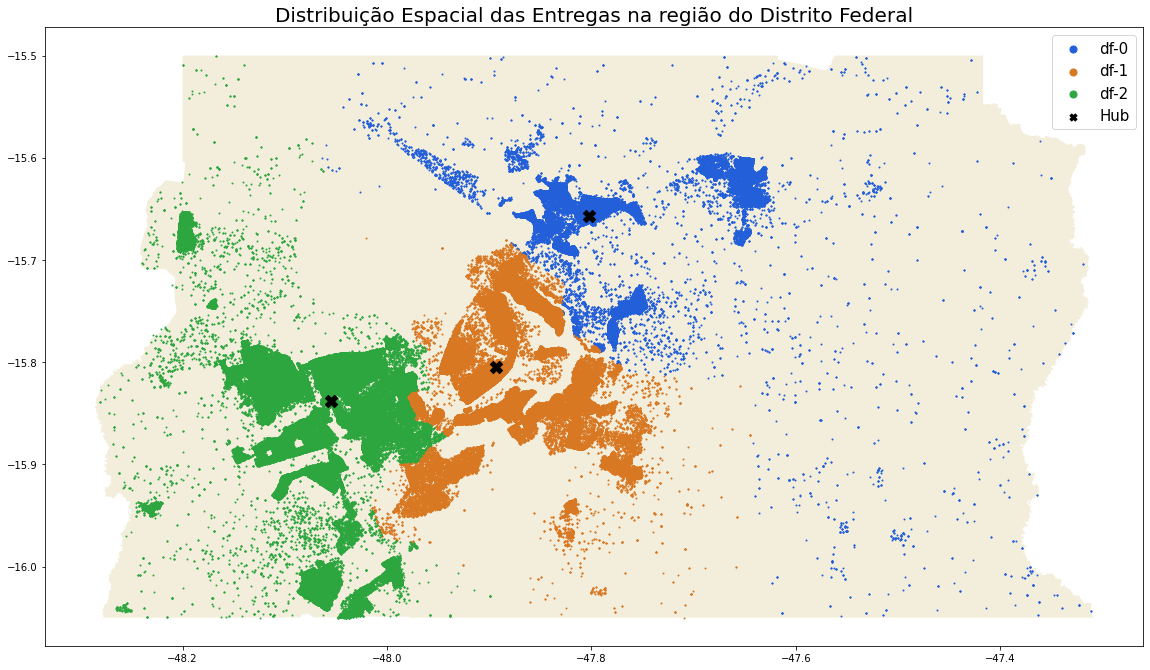

In [59]:
# criando a vistualização do mapa:
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# Exibindo o mapa do distrito federal:
df_map.plot(ax=ax, alpha=0.9, color="#F2EDD7")

# Distribuição espacial das entregas
df_geo_deliveries.query("region == 'df-0'").plot(ax=ax, markersize=1, color="#235FD9", label="df-0")
df_geo_deliveries.query("region == 'df-1'").plot(ax=ax, markersize=1, color="#D97823", label="df-1")
df_geo_deliveries.query("region == 'df-2'").plot(ax=ax, markersize=1, color="#2EA640", label="df-2")

# Posição dos Hub's:
df_geo_hub.plot(ax=ax, markersize=150, marker="X", color="black", label="Hub")

# Inserindo legenda e tamanho da fonte:
plt.title("Distribuição Espacial das Entregas na região do Distrito Federal", fontdict={"fontsize": 20})
lgnd = plt.legend(prop={"size": 15})
for lhandle in lgnd.legendHandles:
    lhandle.set_sizes([50])



Como o mapa acima não possibilita uma percepção clara, sobre qual ponto de distribuição apresentam maior preponderância. Diante disso, será necessário construir gráficos que auxiliem nessa compreensão.

###5.2 Visualização Gráfica

,region,number_deliveries
0,df-0,385932
1,df-1,1681582
2,df-2,1439010


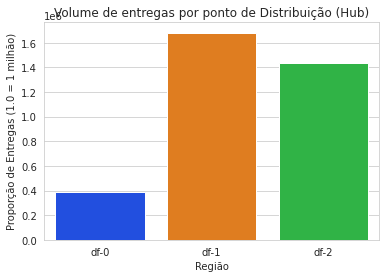

In [29]:
# Criando o DataFrame para observar a capacidade de entregas de cada Hub:
# Selecionando as colunas "region" e "deliveries_size":
df_capacidade_entrega = df_geo_deliveries[['region','deliveries_size']]

# Agrupando os dados em relação ao Hubs e somando a quantidade de entrega:
df_capacidade_entrega = df_capacidade_entrega.groupby('region').sum()

# transformando o index em coluna para facilitar sua exibição no gráfico:
df_capacidade_entrega.reset_index(inplace=True)

# Renomeando a coluna deliveries_size:
df_capacidade_entrega.rename(columns={'deliveries_size':'number_deliveries'}, inplace=True)

# Exibindo o DataFrame:
display(df_capacidade_entrega)

# Criando o gráfico de barras para visualização do volume de entregas por Hub:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=df_capacidade_entrega, x="region", y="number_deliveries", ci=None, palette="bright")
  grafico.set(title="Volume de entregas por ponto de Distribuição (Hub)", xlabel='Região', ylabel='Proporção de Entregas (1.0 = 1 milhão)')


,region,vehicle_capacity,deliveries_proportion
2,df-0,180,11.02
0,df-1,180,47.90
1,df-2,180,41.08


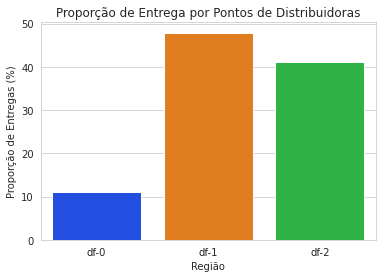

In [30]:
# Criando o DataFrame com a proporção de entregas por Hub:
df_prop_entrega = df_geo_deliveries[['region', 'vehicle_capacity']]

# Calculando a proporção através do value_counts e seu atributo normalize:
df_prop_entrega = round(df_prop_entrega.value_counts(normalize=True)*100,2)

# Transformando o resultado do cálculo em DataFrame:
df_prop_entrega = df_prop_entrega.to_frame()

# Reestruturando o DataFrame
df_prop_entrega.reset_index(inplace=True)

# Renomeando as colunas:
df_prop_entrega.rename(columns={0:'deliveries_proportion'}, inplace=True)

# Organizando as informações por região:
df_prop_entrega.sort_values(by='region', inplace=True)

# Exibindo o DataFrame:
display(df_prop_entrega)

# Criando o gráfico de barras para visualização a proporção de entregas:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=df_prop_entrega, x="region", y="deliveries_proportion", ci=None, palette="bright")
  grafico.set(title="Proporção de Entrega por Pontos de Distribuidoras", xlabel='Região', ylabel='Proporção de Entregas (%)')


,region,average_deliveries_distance
0,df-0,9.02
1,df-1,5.96
2,df-2,7.90


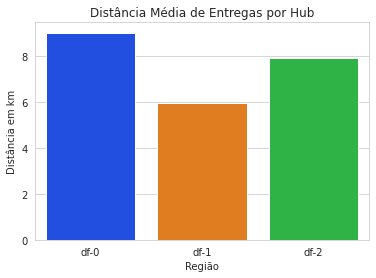

In [31]:
# Criando um DataFrame para registrar a média da distância percorrida 
# por cada Hub para realizar suas entregas:
df_delivery_distance = df_geo_deliveries[['region','delivery_distance']]

# Agrupando os dados em relação ao Hubs e calculando a média da distância percorrida:
df_delivery_distance = df_delivery_distance.groupby('region').mean()

# Renomeando a coluna delivery_distance:
df_delivery_distance.rename(columns={'delivery_distance':'average_deliveries_distance'}, inplace=True)

# Arredondando o resultado da média das distâncias para duas casa decimais:
df_delivery_distance['average_deliveries_distance'] = df_delivery_distance['average_deliveries_distance'].round(2)

# transformando o index em coluna para facilitar sua exibição no gráfico:
df_delivery_distance.reset_index(inplace=True)

# Exibindo o DataFrame:
display(df_delivery_distance)

# Criando o gráfico de barras para visualização da distância média percorrida por cada Hub:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=df_delivery_distance, x="region", y="average_deliveries_distance", ci=None, palette="bright")
  grafico.set(title="Distância Média de Entregas por Hub", xlabel='Região', ylabel='Distância em km')


,region,average_deliveries_size
0,df-0,5.50
1,df-1,5.52
2,df-2,5.51


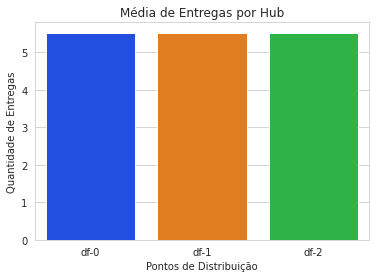

In [32]:
# Criando DataFrame para o registro da média do volume de entrega por Hub:
df_average_deliveries_size = df_geo_deliveries[['region','deliveries_size']]

# Agrupando os dados em relação ao Hubs e calculando a média do volume de entregas:
df_average_deliveries_size = df_average_deliveries_size.groupby(by=['region']).mean()

# Renomeando a coluna deliveries_size:
df_average_deliveries_size.rename(columns={'deliveries_size':'average_deliveries_size'}, inplace=True)

# Arredondando o resultado da média da quantidade de entrega por Hub:
df_average_deliveries_size['average_deliveries_size'] = df_average_deliveries_size['average_deliveries_size'].round(2)

# transformando o index 'region' em coluna para facilitar seu uso no gráfico:
df_average_deliveries_size.reset_index(inplace=True)

# Exibindo o DataFrame:
display(df_average_deliveries_size)

# Criando o gráfico de barras para visualização da distância média percorrida por cada Hub:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=df_average_deliveries_size, x="region", y="average_deliveries_size", ci=None, palette="bright")
  grafico.set(title="Média de Entregas por Hub", xlabel='Pontos de Distribuição', ylabel='Quantidade de Entregas')


##Insights
---

Com base nos gráficos expostos acima, é perceptível que o Hub de Sobradinho (df-0) representa a menor participação no número de entregas do Distrito Federal, tendo uma contribuição de apenas 11.02% do número de entregas da região. Porém, a distância média das entregas desse ponto de distribuição, é superior aos demais Hub's. Talvez, esse aspecto de sua distância média elevada, seja explicado pelo fato desse hub atender regiões mais interioranas.

Já o ponto de distribuição de Brasília (df-1), representa a maior participação no número de entregas da região, contabilizando 47.9% da proporção total. Além disso, esse Hub conta com a vantagem de apresentar a menor distância média para realização de entregas. Tal fenômeno, pode ser explicado pela sua geolocalização, que possibilita a maior proximidade aos seus pontos de entregas.


Por fim, o ponto de distribuição de Taguatinga (df-2), apresenta uma proporção no volume de entregas muito próximo ao df-1, com uma participação total de 41.08%. Além disso, sua distância média por entrega é mais elevada, chegando a quase 8 km por entregas, isso é  um reflexo de sua proximidade a grandes centros populacionais.

Em resumo geral, não possível declarar a existência de pontos de distribuição com demanda ociosa com base nos dados disponibilizados. Outro aspecto importante, é o fato da relação apresentada; que quanto maior for a distância média, menor vai ser  a quantidade total de entregas realizadas. Diante disso, a Loggi poderia fazer um estudo de caso e analisar a possibilidade de implementar um novo ponto de distribuição nas proximidades do df-0, para impulsionar essa demanda reprimida.